[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



===== Model Performance =====
Accuracy  : 0.7265
Precision : 0.7631
Recall    : 0.6570
F1-Score  : 0.7061
ROC-AUC   : 0.8084

===== Classification Report =====
              precision    recall  f1-score   support

    Negative       0.70      0.80      0.74      1000
    Positive       0.76      0.66      0.71      1000

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



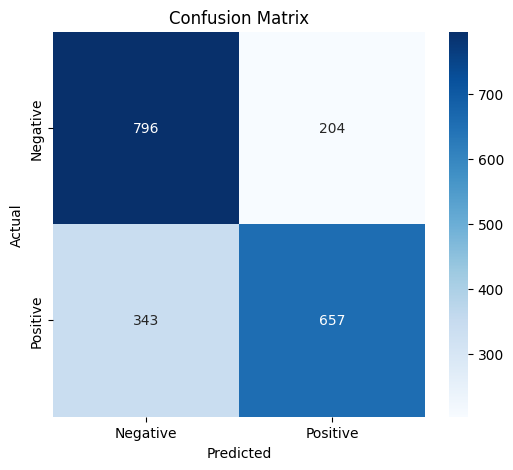

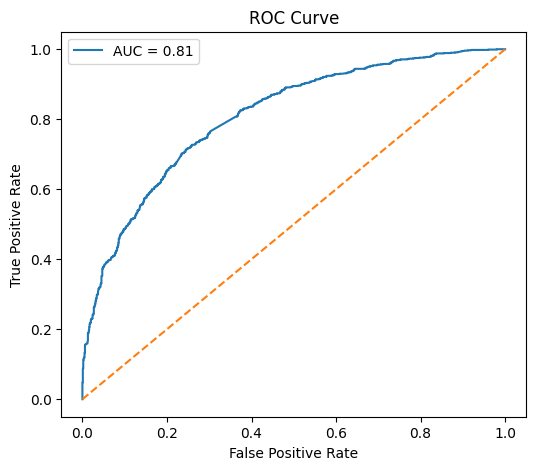


Cross-Validation Accuracy: 0.7309
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4669951560d5222f2b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ===========================================================
# Semantic Analysis of Twitter Data (Research-Grade)
# TF-IDF + LSA + Linear SVM + Gradio GUI
# ===========================================================

# -----------------------------
# 1. Import Libraries
# -----------------------------
import nltk
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

from nltk.corpus import twitter_samples, stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# -----------------------------
# 2. Download NLTK Resources
# -----------------------------
nltk.download('twitter_samples')
nltk.download('stopwords')

# -----------------------------
# 3. Load Dataset
# -----------------------------
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

df_pos = pd.DataFrame({'tweet': positive_tweets, 'label': 1})
df_neg = pd.DataFrame({'tweet': negative_tweets, 'label': 0})

df = pd.concat([df_pos, df_neg]).reset_index(drop=True)

# -----------------------------
# 4. Preprocessing
# -----------------------------
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+", "", tweet)
    tweet = re.sub(r"@\w+", "", tweet)
    tweet = re.sub(r"#", "", tweet)
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    tokens = tokenizer.tokenize(tweet)
    tokens = [
        stemmer.stem(word) for word in tokens
        if word not in stop_words and len(word) > 2
    ]
    return " ".join(tokens)

df["clean_tweet"] = df["tweet"].apply(preprocess_tweet)

# -----------------------------
# 5. Train-Test Split
# -----------------------------
X = df["clean_tweet"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# -----------------------------
# 6. TF-IDF Vectorization (Improved)
# -----------------------------
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    min_df=3,
    max_df=0.85
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# -----------------------------
# 7. Latent Semantic Analysis (LSA)
# -----------------------------
lsa = TruncatedSVD(n_components=300, random_state=42)
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

# -----------------------------
# 8. Linear SVM Classifier (BEST for Text)
# -----------------------------
svm = SVC(
    kernel="linear",
    C=1.5,
    probability=True,
    class_weight="balanced",
    random_state=42
)

svm.fit(X_train_lsa, y_train)

# -----------------------------
# 9. Evaluation
# -----------------------------
y_pred = svm.predict(X_test_lsa)
y_proba = svm.predict_proba(X_test_lsa)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n===== Model Performance =====")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")

print("\n===== Classification Report =====")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# -----------------------------
# 10. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# 11. ROC Curve
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# -----------------------------
# 12. Cross-Validation (Research Stability)
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm, X_train_lsa, y_train, cv=cv, scoring="accuracy")

print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f}")

# -----------------------------
# 13. Prediction Function (GUI)
# -----------------------------
def predict_sentiment(tweet):
    clean = preprocess_tweet(tweet)
    tfidf = vectorizer.transform([clean])
    lsa_vec = lsa.transform(tfidf)
    proba = svm.predict_proba(lsa_vec)[0]
    confidence = np.max(proba)

    if confidence < 0.65:
        return "Sentiment: Neutral / Uncertain"

    label = "Positive" if np.argmax(proba) == 1 else "Negative"
    return f"Sentiment: {label} (Confidence: {confidence*100:.2f}%)"

# -----------------------------
# 14. Gradio GUI
# -----------------------------
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(label="Enter Tweet"),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Semantic Analysis of Twitter Data",
    description="TF-IDF + LSA + Linear SVM (Research-Grade Sentiment Analysis)",
    examples=[
        ["I absolutely love this new phone!"],
        ["Worst experience ever, totally disappointed."],
        ["The movie was okay, nothing special."],
        ["Service was fast but food quality was average."]
    ]
)

interface.launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 16.1 MB/s eta 0:00:00
Using device: cuda
Loading and filtering dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/45615 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12284 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24942 [00:00<?, ? examples/s]

Map:   0%|          | 0/6347 [00:00<?, ? examples/s]

Map:   0%|          | 0/1131 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/24942 [00:00<?, ? examples/s]

Map:   0%|          | 0/6347 [00:00<?, ? examples/s]

Map:   0%|          | 0/1131 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1982595353.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training started...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.315600,0.225560,0.903625,0.931490,0.959845,0.904762,0.963677
2,0.154100,0.259190,0.920424,0.945255,0.941818,0.948718,0.965501



--- FINAL TEST RESULTS ---


eval_loss: 0.2966
eval_accuracy: 0.9119
eval_f1: 0.8889
eval_precision: 0.8419
eval_recall: 0.9415
eval_roc_auc: 0.9716
eval_runtime: 3.9648
eval_samples_per_second: 1600.8170
eval_steps_per_second: 100.1300
epoch: 2.0000

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.89      0.93      3972
    Positive       0.84      0.94      0.89      2375

    accuracy                           0.91      6347
   macro avg       0.90      0.92      0.91      6347
weighted avg       0.92      0.91      0.91      6347



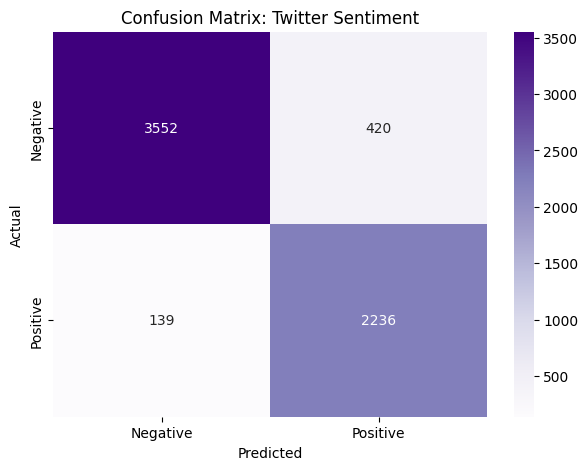

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bbf7d3e9b166124ed2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# Transformer-Based Twitter Sentiment Analysis (Optimized)
# Model: DistilBERT-base-uncased
# Dataset: TweetEval (Binary Sentiment)
# ============================================================

# 1. INSTALL DEPENDENCIES
# -----------------------------
!pip install -q transformers[torch] datasets gradio emoji accelerate scikit-learn matplotlib seaborn

import re
import emoji
import numpy as np
import torch
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    classification_report
)

# 2. SETUP & DEVICE
# -----------------------------
MODEL_NAME = "distilbert-base-uncased" # Faster and more efficient than BERT-base
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3. LOAD & PREPROCESS DATASET
# -----------------------------
print("Loading and filtering dataset...")
raw_datasets = load_dataset("tweet_eval", "sentiment")

def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text) # Remove URLs
    text = re.sub(r"@\w+", "@user", text)      # Normalize Mentions
    text = re.sub(r"#", "", text)               # Remove hashtag symbol
    text = emoji.demojize(text)                # Convert emojis to text
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Map labels: Original (0:Neg, 1:Neu, 2:Pos) -> Binary (0:Neg, 1:Pos)
def prepare_binary_data(example):
    return {"is_neutral": example["label"] == 1}

# Filter out neutrals and map Pos(2) to 1
dataset = raw_datasets.filter(lambda x: x["label"] != 1)
dataset = dataset.map(lambda x: {"label": 1 if x["label"] == 2 else 0})

# 4. TOKENIZATION
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    texts = [clean_tweet(t) for t in examples["text"]]
    return tokenizer(texts, truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Subsampling for speed (adjust range for better accuracy)
train_set = tokenized_datasets["train"].shuffle(seed=42).select(range(15000))
val_set = tokenized_datasets["validation"]
test_set = tokenized_datasets["test"]

# 5. MODEL & COMPREHENSIVE METRICS
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate probabilities for ROC-AUC
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    auc = roc_auc_score(labels, probs)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": auc
    }

# 6. TRAINING CONFIGURATION
# -----------------------------
training_args = TrainingArguments(
    output_dir="./twitter_sentiment_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(), # Speed up on GPU
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 7. TRAIN & EVALUATE
# -----------------------------
print("Training started...")
trainer.train()

print("\n--- FINAL TEST RESULTS ---")
final_results = trainer.evaluate(test_set)
for k, v in final_results.items():
    print(f"{k}: {v:.4f}")

# 8. VISUAL EVALUATION (Confusion Matrix)
# -----------------------------
preds_output = trainer.predict(test_set)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=-1)

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix: Twitter Sentiment')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 9. INFERENCE FUNCTION & GRADIO GUI
# -----------------------------
def predict_sentiment(text):
    if not text.strip(): return "Please enter text."

    inputs = tokenizer(clean_tweet(text), return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits

    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    confidences = {
        "Negative": float(probs[0]),
        "Positive": float(probs[1])
    }
    return confidences

# Launch Interface
gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(label="Enter Tweet Content", placeholder="The product was amazing!"),
    outputs=gr.Label(num_top_classes=2, label="Sentiment Confidence"),
    title="Sentiment Analysis Pro: DistilBERT",
    description="Full-cycle Transformer model with evaluation metrics (F1, AUC, Precision, Recall).",
    theme="soft",
    examples=["This service is terrible.", "I had a wonderful time!", "It's okay, not the best."]
).launch(share=True)